### Importing

In [1]:
import os
import glob
import pandas as pd
import numpy as np
np.random.seed(42)
import random
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import plot_importance
from scipy.stats import multivariate_normal
import scipy.stats as stats
import scipy
import math

## Data Importing

In [2]:
# Specify the relative path to the data directory
data_folder_path = "C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Data"
non_games_data_folder_path = "C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Non_Games_Data"

# List all files in the data folder
file_list = os.listdir(data_folder_path)
file_list_non_games = os.listdir(non_games_data_folder_path)

# Use glob to filter specific file types
csv_files = glob.glob(os.path.join(data_folder_path, "*.csv"))
csv_files_non_games = glob.glob(os.path.join(non_games_data_folder_path, "*.csv"))

# Read in the weekly game data and concat into one combined df
dfs = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(dfs, ignore_index=True)

# Read in the supplementary data
games = pd.read_csv(csv_files_non_games[0])
nfl_colors = pd.read_csv(csv_files_non_games[1])
pff_scouting_data = pd.read_csv(csv_files_non_games[2])
players = pd.read_csv(csv_files_non_games[3])
plays = pd.read_csv(csv_files_non_games[4])

In [3]:

clean_df = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/clean_df.csv")
ClusterDF = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/ClusterDF.csv")
RoutesDf = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/RoutesDf.csv")
StuntDF = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/StuntDF.csv")
C_AdjustedDF = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/C_AdjustedDF.csv")
recivers = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Non_Games_Data/receiving_summary2021.csv")

team_join = plays[["gameId", "playId", "possessionTeam", "defensiveTeam"]]

In [34]:
ModelingDF = RoutesDf.copy()

ModelingDF = ModelingDF[["gameId", "playId", "nflId", "jerseyNumber", "frameId", "pff_positionLinedUp", "team", "s", "a", "dir", "clean_dir", "clean_o", "x", "y"]]

ModelingDF = pd.merge(ModelingDF, ClusterDF, on=["gameId", "playId"])

ModelingDF = pd.merge(ModelingDF, C_AdjustedDF, on=["gameId", "playId", "nflId", "frameId"])

ModelingDF.sort_values(by=["gameId", "playId", "nflId", "frameId"], inplace=True)
ModelingDF["Next_CAX"] = ModelingDF.groupby(["gameId", "playId", "nflId"])["C_adjusted_x"].shift(-1)
ModelingDF["Next_CAY"] = ModelingDF.groupby(["gameId", "playId", "nflId"])["C_adjusted_y"].shift(-1)

ModelingDF = ModelingDF.dropna()

ModelingDF = pd.get_dummies(ModelingDF, columns=['pff_positionLinedUp'])

In [54]:
game_ids = list(ModelingDF['gameId'].unique())

random.seed(42)

train_index = random.sample(game_ids, int(16 * 0.8))



train_x = ModelingDF[ModelingDF["gameId"].apply(lambda x: x in train_index)].iloc[:, np.r_[6:8, 9:11, 13:223, 227:275]]

train_y_x = ModelingDF[ModelingDF["gameId"].apply(lambda x: x in train_index)]["Next_CAX"].astype(int)
train_y_y = ModelingDF[ModelingDF["gameId"].apply(lambda x: x in train_index)]["Next_CAY"].astype(int)

test_x = ModelingDF[ModelingDF["gameId"].apply(lambda x: x not in train_index)].iloc[:, np.r_[6:8, 9:11, 13:223, 227:275]]

test_y = ModelingDF[ModelingDF["gameId"].apply(lambda x: x not in train_index)]["Next_CAY"].astype(int)



## Modeling

In [55]:
xgbooster = xgb.XGBRegressor()

clf_x = GridSearchCV(xgbooster, {'max_depth': [1, 2, 4, 6, 8, 10],
                            'n_estimators': [10, 25, 50, 100, 200, 500, 1000]}, verbose=1)
clf_x.fit(train_x, train_y_x)


#xgbpredictions = clf.predict(test_x)

#errorRate = np.sqrt(metrics.mean_squared_error(test_y, xgbpredictions))
#print(errorRate)


clf_y = GridSearchCV(xgbooster, {'max_depth': [1, 2, 4, 6, 8, 10],
                            'n_estimators': [10, 25, 50, 100, 200, 500, 1000]}, verbose=1)
clf_y.fit(train_x, train_y_y)


Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10],
                         'n_estimators': [10, 25, 50, 100, 200, 500, 1000]},
             verbose=1)

In [56]:
# Merge Predictions back to modelingDF

Model_Inputs = ModelingDF.iloc[:, np.r_[6:8, 9:11, 13:223, 227:275]]

ModelingDF["Model_x"] = clf_x.predict(Model_Inputs)

ModelingDF["Model_y"] = clf_y.predict(Model_Inputs)


## Voronoi Tesselations

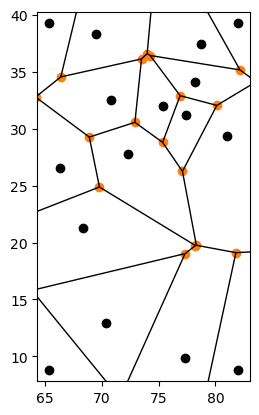

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

VOR_df = ModelingDF.copy()

VOR_df = pd.merge(VOR_df, team_join, on = ["gameId", "playId"])

VOR_df = VOR_df[(VOR_df["gameId"] == 2021090900) & (VOR_df["playId"] == 187) & (VOR_df["frameId"] == 6) ]

bounding_lowerL = {"gameId" : 2021090900, "playId" : 187, "frameId" : 6, "x" : VOR_df['x'].min() - 1, "y" : VOR_df['y'].min() - 1}
bounding_upperL = {"gameId" : 2021090900, "playId" : 187, "frameId" : 6, "x" : VOR_df['x'].max() + 1, "y" : VOR_df['y'].max() + 1}
bounding_lowerR = {"gameId" : 2021090900, "playId" : 187, "frameId" : 6, "x" : VOR_df['x'].min() - 1, "y" : VOR_df['y'].max() + 1}
bounding_upperR = {"gameId" : 2021090900, "playId" : 187, "frameId" : 6, "x" : VOR_df['x'].max() + 1, "y" : VOR_df['y'].min() - 1}

bounding_lowerL = pd.DataFrame([bounding_lowerL])
bounding_upperL = pd.DataFrame([bounding_upperL])
bounding_lowerR = pd.DataFrame([bounding_lowerR])
bounding_upperR = pd.DataFrame([bounding_upperR])


VOR_df = pd.concat([VOR_df, bounding_lowerL], ignore_index=True)
VOR_df = pd.concat([VOR_df, bounding_upperL], ignore_index=True)
VOR_df = pd.concat([VOR_df, bounding_lowerR], ignore_index=True)
VOR_df = pd.concat([VOR_df, bounding_upperR], ignore_index=True)


points = VOR_df[['x', 'y']].values

# Create a Voronoi diagram
vor = Voronoi(points)

# Plot the Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax)

# Plot the original points if needed
ax.plot(points[:, 0], points[:, 1], 'ko')

# Customize the plot if desired
plt.xlim(VOR_df['x'].min() - 1, VOR_df['x'].max() + 1)
plt.ylim(VOR_df['y'].min() - 1, VOR_df['y'].max() + 1)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [5]:
StarPlayers = [52430, 41282, 42489, 43454, 44881, 41233, 40011, 53434, 47834]

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import math

VOR_df = ModelingDF.copy()

VOR_df = pd.merge(VOR_df, team_join, on = ["gameId", "playId"])

#VOR_df = VOR_df[(VOR_df["gameId"] == 2021090900)]

VOR_df['area'] = np.nan
VOR_df['exp_area'] = np.nan

VOR_df['Time'] = VOR_df.groupby(['gameId', 'playId'])['frameId'].transform(lambda x: x - x.min() + 1)
VOR_df['WithinDown'] = VOR_df['Time'] / 25

VOR_df.fillna(0, inplace=True)

def calculate_adjusted_change(row):
    if row['Time'] < 25:
        return row['area_percentage_change'] / (math.log(row['Time'] + 1, 26))
    else:
        return row['area_percentage_change']



def Calculate_Gravity(playerCoordinates = []):

    TotalGravity = pd.DataFrame()

    unique_frames = playerCoordinates["frameId"].unique()


    for frame in unique_frames:

        frame_data = playerCoordinates[playerCoordinates["frameId"] == frame]

        bounding_lowerL = {'x' : frame_data['x'].min() - 1, 'y' : frame_data['y'].min() - 1, 
                           'Average_Cluster_CAX' : frame_data['Model_x'].min() - 1, 'Average_Cluster_CAY' : frame_data['Model_y'].min() - 1}
        bounding_upperL = {'x' : frame_data['x'].max() + 1, 'y' : frame_data['y'].max() + 1,
                           'Average_Cluster_CAX' : frame_data['Model_x'].max() + 1, 'Average_Cluster_CAY' : frame_data['Model_y'].max() + 1}
        bounding_lowerR = {'x' : frame_data['x'].min() - 1, 'y' : frame_data['y'].max() + 1,
                           'Average_Cluster_CAX' : frame_data['Model_x'].min() - 1, 'Average_Cluster_CAY' : frame_data['Model_y'].max() + 1}
        bounding_upperR = {'x' : frame_data['x'].max() + 1, 'y' : frame_data['y'].min() - 1,
                           'Average_Cluster_CAX' : frame_data['Model_x'].max() + 1, 'Average_Cluster_CAY' : frame_data['Model_y'].min() - 1}

        bounding_lowerL = pd.DataFrame([bounding_lowerL])
        bounding_upperL = pd.DataFrame([bounding_upperL])
        bounding_lowerR = pd.DataFrame([bounding_lowerR])
        bounding_upperR = pd.DataFrame([bounding_upperR])


        frame_data = pd.concat([frame_data, bounding_lowerL], ignore_index=True)
        frame_data = pd.concat([frame_data, bounding_upperL], ignore_index=True)
        frame_data = pd.concat([frame_data, bounding_lowerR], ignore_index=True)
        frame_data = pd.concat([frame_data, bounding_upperR], ignore_index=True)


        points = frame_data[['x', 'y']].dropna().values

        # Create a Voronoi diagram
        vor = Voronoi(points)

        # Iterate through the input points
        for i, point in enumerate(points):
            # Find the Voronoi region index for the current point
            region_index = vor.point_region[i]
            
            # Get the vertices of the region
            region_vertices = vor.regions[region_index]
            
            # Filter out invalid vertices
            region_vertices = [vertex for vertex in region_vertices if vertex != -1]
            
            if len(region_vertices) > 0:
                # Get the vertices of the region
                vertices = vor.vertices[region_vertices]
                
                # Calculate the area using the Shoelace formula
                area = 0.5 * np.abs(np.dot(vertices[:, 0], np.roll(vertices[:, 1], 1)) -
                                np.dot(vertices[:, 1], np.roll(vertices[:, 0], 1)))
                
                # Store the area in the 'area' column of VOR_df for the current point
                frame_data.at[i, 'area'] = area

        ''' DO IT AGAIN FOR EXPECTED'''

        exp_points = frame_data[['Average_Cluster_CAX', 'Average_Cluster_CAY']].dropna().values

        # Create a Voronoi diagram
        exp_vor = Voronoi(exp_points)

        # Iterate through the input points
        for i, point in enumerate(exp_points):
            # Find the exp_voronoi region index for the current point
            exp_region_index = exp_vor.point_region[i]
            
            # Get the vertices of the region
            exp_region_verticies = exp_vor.regions[exp_region_index]
            
            # Filter out invalid vertices
            exp_region_verticies = [vertex for vertex in exp_region_verticies if vertex != -1]
            
            if len(exp_region_verticies) > 0:
                # Get the vertices of the region
                exp_verticies = exp_vor.vertices[exp_region_verticies]
                
                # Calculate the area using the Shoelace formula
                exp_area = 0.5 * np.abs(np.dot(exp_verticies[:, 0], np.roll(exp_verticies[:, 1], 1)) -
                                np.dot(exp_verticies[:, 1], np.roll(exp_verticies[:, 0], 1)))
                
                # Store the area in the 'area' column of VOR_df for the current point
                frame_data.at[i, 'exp_area'] = exp_area

        TotalGravity = pd.concat([TotalGravity, frame_data], ignore_index=True) 

        TotalGravity.dropna(subset = ["gameId"], inplace = True)

        TotalGravity['area_diff'] = TotalGravity['exp_area'] - TotalGravity['area']


        # Sort the DataFrame by the grouping columns and frameId in ascending order
        TotalGravity.sort_values(by=['gameId', 'playId', 'nflId', 'frameId'], inplace=True)

        # Calculate the percentage change in the 'area' column within each group
        TotalGravity['area_percentage_change'] = TotalGravity.groupby(['gameId', 'playId', 'nflId'])['area_diff'].diff()

        TotalGravity['area_percentage_change'].fillna(0, inplace=True)

        # Create the 'adjusted_change' column by applying the custom function to each row
        TotalGravity['adjusted_change'] = TotalGravity.apply(calculate_adjusted_change, axis=1)

        # Calculate the rolling average for 'adjusted_change' when 'Time' is greater than or equal to 25
        TotalGravity['adjusted_change'] = TotalGravity['adjusted_change'].where(TotalGravity['Time'] < 25, TotalGravity['adjusted_change'].rolling(5, min_periods=1).mean())

        TotalGravity["Play_Gravity"] = TotalGravity.groupby(["gameId", "playId", "nflId"])["adjusted_change"].transform("sum")
        TotalGravity["Game_Gravity"] = TotalGravity.groupby(["gameId", "nflId"])["adjusted_change"].transform("sum")
        TotalGravity["Total_Gravity"] = TotalGravity.groupby(["nflId"])["adjusted_change"].transform("sum")
        
    return(TotalGravity)



VOR_df = Calculate_Gravity(VOR_df)




In [35]:
#VOR_df.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesRoutesVoronoiManZone.csv", index=False)
#VOR_df = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesRoutesVoronoi.csv")


In [62]:
IQR = stats.iqr(VOR_df["Play_Gravity"])
# Calculate the first quartile (Q1)
Q1 = np.percentile(VOR_df["Play_Gravity"], 25)

# Calculate the third quartile (Q3)
Q3 = np.percentile(VOR_df["Play_Gravity"], 75)


In [92]:
Min_Play_Count = 10


ExtraWork = VOR_df.copy()

man_zone = plays[["gameId", "playId", "pff_passCoverageType"]]
ExtraWork = pd.merge(ExtraWork, man_zone, on = ["gameId", "playId"])

ExtraWork = ExtraWork[ExtraWork["team"] == ExtraWork["possessionTeam"]]

# Group by 'nflId' and count the unique 'frameId' values in each group
play_counts = ExtraWork.groupby('nflId')['playId'].nunique()

# Create a new column 'TotalPlays' in the original DataFrame
ExtraWork['TotalPlays'] = ExtraWork['nflId'].map(play_counts)
FilteredExtraWork = ExtraWork[ExtraWork["TotalPlays"] >= Min_Play_Count]
TotalPlays = FilteredExtraWork[["nflId", "team", "TotalPlays"]]

FilteredExtraWork = FilteredExtraWork.groupby('nflId').apply(lambda x: x[x['Play_Gravity'] <= Q3 + 1.5 * IQR]).reset_index(drop=True)
FilteredExtraWork = FilteredExtraWork.groupby('nflId').apply(lambda x: x[x['Play_Gravity'] >= Q1 - 1.5 * IQR]).reset_index(drop=True)


Summarized = pd.DataFrame()
Summarized["MeanFrame"] = FilteredExtraWork.groupby(["nflId"])["adjusted_change"].mean()
Summarized["MeanPlay"] = FilteredExtraWork.groupby(["nflId"])["Play_Gravity"].mean()
Summarized = Summarized.drop_duplicates()
Summarized.reset_index(inplace=True)
Summarized["StarPlayer"] = np.where(Summarized["nflId"].isin(StarPlayers), 1, 0)
Summarized = Summarized.sort_values(by=['MeanPlay'], ascending = True)

player_name = players[["nflId", "officialPosition", "displayName"]]

Summarized = pd.merge(Summarized, player_name, on = "nflId")
Summarized = pd.merge(Summarized, TotalPlays, on = "nflId")


Summarized = Summarized.drop_duplicates()


recivers["Cluster"] = np.where((recivers["avg_depth_of_target"] >= 10) & (recivers["slot_rate"] <= 49), 1, 
                               np.where((recivers["avg_depth_of_target"] < 10) & (recivers["slot_rate"] <= 49), 0.5,
                                        np.where((recivers["avg_depth_of_target"] >= 10) & (recivers["slot_rate"] > 49), 0.25,
                               0)))

ReceiverClusters = recivers[["nflId", "avg_depth_of_target", "slot_rate", "Cluster"]]

Summarized = pd.merge(Summarized, ReceiverClusters, on = "nflId")


Viewer = FilteredExtraWork[['gameId', 'playId', 'nflId', 'jerseyNumber', "team", 'pff_passCoverageType', 'frameId', 'area', 'area_percentage_change', 'adjusted_change', 'Play_Gravity', 'Game_Gravity', "Total_Gravity"]].drop_duplicates()


In [96]:
TotalTeamByPlay = Viewer.groupby(['gameId', 'playId', "team"])["Play_Gravity"].mean().reset_index()


# Group by 'nflId' and count the unique 'frameId' values in each group
play_counts_split = FilteredExtraWork.groupby(['nflId', 'pff_passCoverageType'])['playId'].nunique().reset_index()


PlayerManZoneSplit = Viewer.groupby(['nflId', 'pff_passCoverageType'])["Play_Gravity"].mean().reset_index()
#PlayerManZoneSplit = PlayerManZoneSplit[PlayerManZoneSplit["nflId"].isin(StarPlayers)]
PlayerManZoneSplit = pd.merge(PlayerManZoneSplit, player_name, on = "nflId")
PlayerManZoneSplit = pd.merge(PlayerManZoneSplit, play_counts_split, on = ['nflId', 'pff_passCoverageType'])
PlayerManZoneSplit = PlayerManZoneSplit[PlayerManZoneSplit["playId"] >= 5]